In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import glob
import time
from sklearn.model_selection import train_test_split
import xgboost
import os
from preprocess import data_preprocessor

In [11]:
%autosave 60

Autosaving every 60 seconds


In [12]:
plt.rcParams["figure.figsize"] = (8, 8)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)
sns.set_style("darkgrid")
os.chdir("/home/cwshpmu2282/Desktop/EVRangePrediction/data/raw/combined_raw_csv/")

In [13]:
from dask import compute, persist
from dask.distributed import Client, progress

client = Client(os.environ.get("DISTRIBUTED_ADDRESS")) 


/home/cwshpmu2282/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


In [14]:
client

Client Scheduler: tcphttps://43985-dot-4948079-dot-devshell.appspot.com Dashboard: https://39148-dot-4948079-dot-devshell.appspot.com/status,Cluster Workers: 8 Cores: 32 Memory: 58.29 GB


In [15]:
file_name='raw.csv'
import dask.dataframe as dd

df=dd.read_csv(file_name)

frac = 0.3
df = df.sample(frac=frac) # we blow out ram otherwise

'''

is_delayed = (df.DepDelay.fillna(16) > 15)

df['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)
del df['DepDelay']

df, is_delayed = persist(df, is_delayed)
progress(df, is_delayed)

'''

"\n\nis_delayed = (df.DepDelay.fillna(16) > 15)\n\ndf['CRSDepTime'] = df['CRSDepTime'].clip(upper=2399)\ndel df['DepDelay']\n\ndf, is_delayed = persist(df, is_delayed)\nprogress(df, is_delayed)\n\n"

In [16]:
df.head()

,Unnamed: 0,EVIRT_Min,EVMGF,EVDI2,EVSOMI,EVBMI_Latest,EVBMA_Latest,EVACS,EVIRT_Max,EVCFN,EVODO,EVPWA_MIN,EVBMA_Min,IMEI,EVBBV,sp,EVACO_Z,EVMGT,EVGPO,EVBMA_Max,EVMSC,EVOAS,EVSOH,EVMGR,EVMGS,EVSMA_MAX,EVTRQ,EVPWA_MAX,EVBFN,EVCOM_Latest,EVVSP,EVIGM_Latest,EVDR1,EVSOMA,EVACP,EVTRE
110750,110750,27,179.0,32.0,100.0,25.0,25.5,1.0000,80,0.0,741.0,0.0,25.0,3.582721e+14,64.0,2135000.0,-212.0,57.2,11.0,25.5,0.2,20.0,100.0,-181.0,2387.0,82.8,28.5,0.0,0.0,44,36.6641,32,0,100.0,47.0588,50.0
72055,72055,16,154.4,21.0,99.8,20.0,21.5,1.8125,80,0.0,714.0,0.0,20.0,3.582721e+14,59.0,485500.0,-253.0,96.4,11.0,21.5,0.0,14.5,100.0,-157.0,2885.0,73.8,96.7,0.0,0.0,36,43.5859,25,0,100.0,70.5882,50.0
185241,185241,32,179.4,27.0,100.0,23.0,24.0,-0.3750,80,0.0,795.0,0.0,24.0,3.582721e+14,65.5,44100.0,-104.0,-15.8,11.0,24.0,0.0,21.0,100.0,-180.6,1158.0,87.4,-15.7,0.0,0.0,35,18.0391,29,0,100.0,0.0000,50.0
162706,162706,17,179.2,25.0,99.9,21.5,22.5,-0.5000,80,0.0,783.0,0.0,20.0,3.582721e+14,54.5,970600.0,-204.0,-16.5,11.0,22.5,0.1,17.0,100.0,-180.8,1682.0,71.1,-16.0,0.0,0.0,49,26.2812,26,0,100.0,0.0000,50.0
95775,95775,27,179.4,32.0,99.6,24.0,25.0,0.2500,80,0.0,728.0,0.0,25.0,3.582721e+14,58.5,637500.0,-212.0,36.1,11.0,25.0,0.0,21.5,100.0,-180.6,1017.0,91.3,37.0,0.0,0.0,42,15.4219,31,0,100.0,29.8039,50.0


In [17]:
#df=data
df = df.dropna()

In [18]:
df=df.drop("Unnamed: 0",axis=1)

In [19]:
%%time

X = df.drop("EVSMA_MAX",axis=1)
y = df.EVSMA_MAX.values

CPU times: user 19.4 ms, sys: 1.04 ms, total: 20.4 ms
Wall time: 18.6 ms


In [20]:
#len(df)

In [21]:
%%time
import dask_xgboost as dxgb
import xgboost as xgb

params= {
    "eta": 0.01,
    "max_depth": 16,
    "subsample": 0.8
}

bst = dxgb.train(client, params, X, y)


CPU times: user 2min 20s, sys: 26 s, total: 2min 46s
Wall time: 9min 38s


/home/cwshpmu2282/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


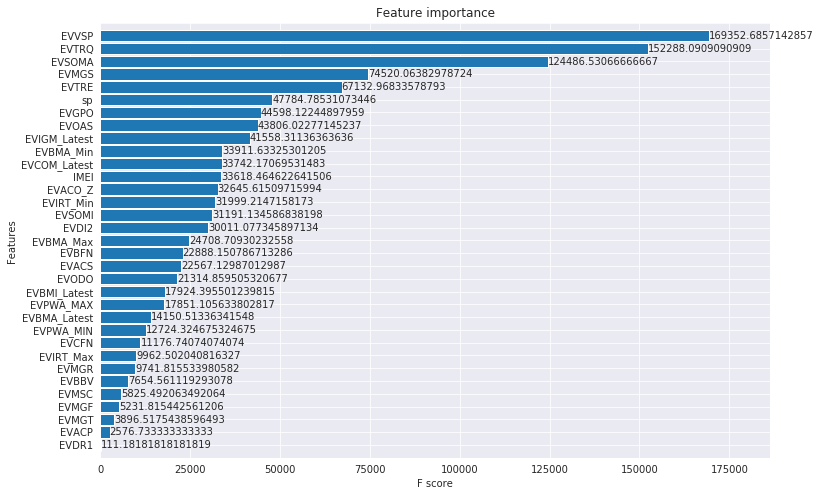

In [26]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.9, importance_type = "cover" )
ax.grid("on", axis="y")



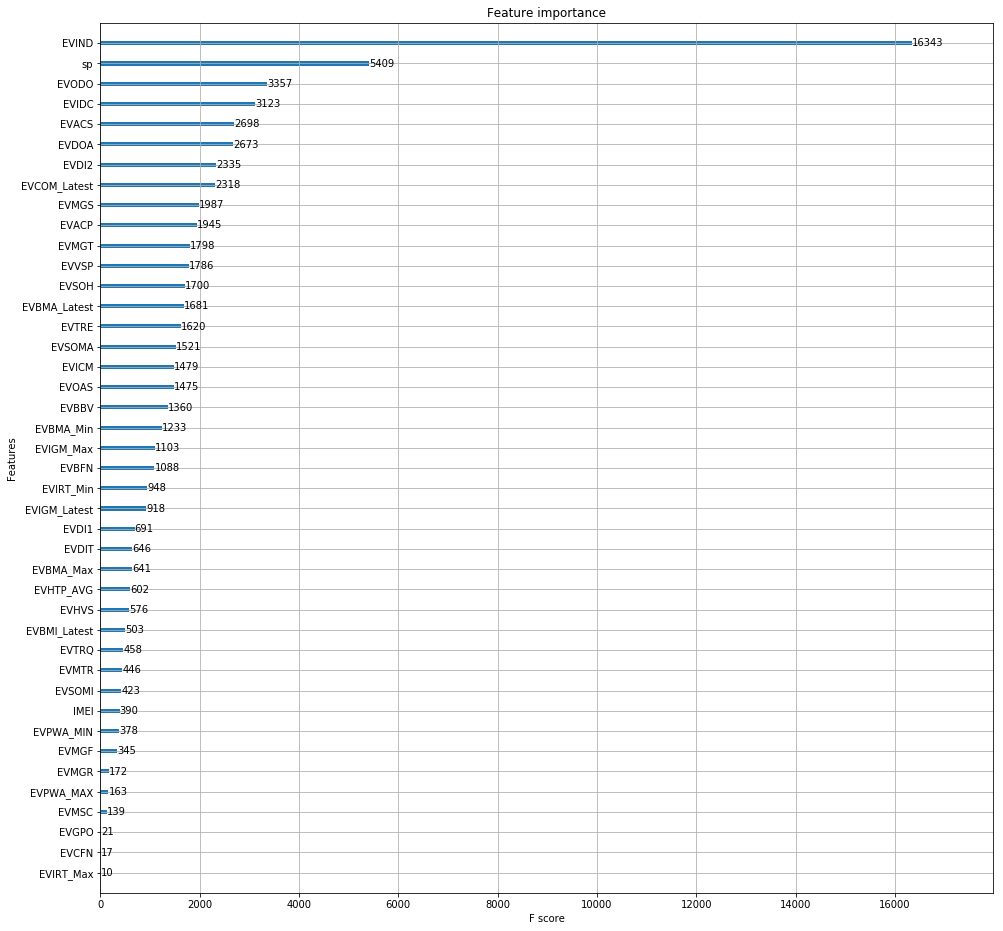

In [30]:
from IPython.display import Image
Image("/home/cwshpmu2282/Pictures/index.png")

/home/cwshpmu2282/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


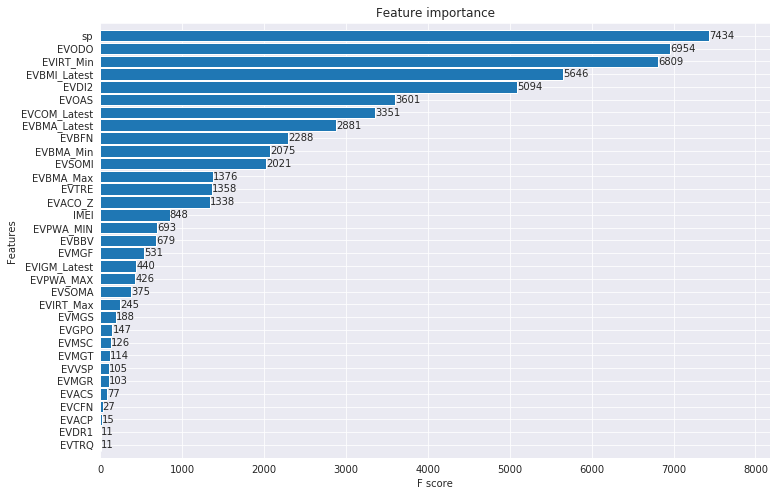

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))

ax = xgb.plot_importance(bst, ax=ax, height=0.9, importance_type = "weight" )
ax.grid("on", axis="y")

In [35]:
import pickle


pickle.dump(bst,open('/home/cwshpmu2282/Desktop/EVRangePrediction/model/xgb.pickel.dat'),'rb')

FileNotFoundError: [Errno 2] No such file or directory: 'xgb.pickel.dat'

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rnd_clf = RandomForestRegressor(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X,y)

importances = rnd_clf.feature_importances_

for name, importance in zip(X, rnd_clf.feature_importances_):
    print(name, "=", importance)